In [3]:
# Instalación de paquetes base
%pip install -q transformers torch pandas matplotlib
%pip install -q scispacy
%pip install -q spacy>=3.7.0,<3.8.0

print("✅ Paquetes base instalados")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: 3.7.0, not found
Note: you may need to restart the kernel to use updated packages.
✅ Paquetes base instalados


In [1]:
# Descarga de modelos scispacy
%pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_scibert-0.5.4.tar.gz
%pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

print("✅ Modelos scispacy descargados")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Modelos scispacy descargados


In [ ]:
import json
import warnings
from datetime import datetime
from collections import defaultdict
warnings.filterwarnings('ignore')

# Transformers (Hugging Face)
from transformers import pipeline

# Spacy y scispacy
import spacy
import scispacy

from scispacy.abbreviation import AbbreviationDetector

# Visualización
import pandas as pd
import matplotlib.pyplot as plt

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [3]:
# Modelo 1: Hugging Face - Biomedical NER (General)
print("⏳ Cargando modelo Hugging Face...")
ner_hf = pipeline(
    "token-classification",
    model="d4data/biomedical-ner-all",
    aggregation_strategy="simple"
)
print("✅ Modelo Hugging Face listo")

⏳ Cargando modelo Hugging Face...


Device set to use mps:0


✅ Modelo Hugging Face listo


In [7]:
nlp_scibert = spacy.load("en_core_sci_scibert")
nlp_scibert.add_pipe("abbreviation_detector")
print("✅ SciBERT + AbbreviationDetector listo")

✅ SciBERT + AbbreviationDetector listo


In [17]:
nlp_bc5cdr = spacy.load("en_ner_bc5cdr_md") 

In [8]:
def extraer_entidades_multimodelo(texto):
    """
    Extrae entidades usando múltiples modelos y las consolida.
    
    Args:
        texto: Texto clínico a procesar
    
    Returns:
        dict con entidades de cada modelo
    """
    resultados = {}
    
    # 1. Hugging Face NER
    print("  🔍 Ejecutando NER con Hugging Face...")
    resultados['hf'] = ner_hf(texto)
    
    # 2. scispacy SciBERT
    print("  🔍 Ejecutando NER con SciBERT...")
    doc_scibert = nlp_scibert(texto)
    resultados['scibert'] = doc_scibert
    
    # 3. scispacy BC5CDR
    print("  🔍 Ejecutando NER con BC5CDR...")
    doc_bc5cdr = nlp_bc5cdr(texto)
    resultados['bc5cdr'] = doc_bc5cdr
    
    return resultados

print("✅ Función de extracción multi-modelo definida")

✅ Función de extracción multi-modelo definida


In [9]:
def detectar_contexto(texto, entidad_texto, posicion):
    """
    Detecta el contexto de una entidad (temporal, negación, certeza).
    
    Args:
        texto: Texto completo
        entidad_texto: Texto de la entidad
        posicion: Tupla (inicio, fin) de la entidad
    
    Returns:
        dict con información de contexto
    """
    inicio, fin = posicion
    
    # Obtener ventana de contexto (50 caracteres antes y después)
    ventana_inicio = max(0, inicio - 50)
    ventana_fin = min(len(texto), fin + 50)
    contexto = texto[ventana_inicio:ventana_fin].lower()
    
    resultado = {}
    
    # Detección de temporalidad
    patrones_temporal = {
        "antecedente": ["antecedentes", "antecedente de", "historia de", "diagnosticado hace"],
        "actual": ["actualmente", "acude por", "presenta", "refiere", "motivo de consulta"],
        "pasado": ["hace", "desde hace", "años de evolución", "meses de evolución", "días de evolución"]
    }
    
    for tipo, patrones in patrones_temporal.items():
        if any(patron in contexto for patron in patrones):
            resultado["temporalidad"] = tipo
            break
    
    # Detección de negación
    patrones_negacion = ["niega", "sin", "no presenta", "se descarta", "negativo", "ausencia de"]
    resultado["negacion"] = any(patron in contexto for patron in patrones_negacion)
    
    # Detección de certeza
    if any(palabra in contexto for palabra in ["confirmado", "diagnosticado", "evidencia de"]):
        resultado["certeza"] = "confirmado"
    elif any(palabra in contexto for palabra in ["probable", "posible", "sospecha"]):
        resultado["certeza"] = "probable"
    else:
        resultado["certeza"] = "mencionado"
    
    return resultado

print("✅ Función de detección de contexto definida")

✅ Función de detección de contexto definida


In [13]:
def detectar_contexto(texto, entidad_texto, posicion):
    """
    Detecta el contexto de una entidad (temporal, negación, certeza).
    
    Args:
        texto: Texto completo
        entidad_texto: Texto de la entidad
        posicion: Tupla (inicio, fin) de la entidad
    
    Returns:
        dict con información de contexto
    """
    inicio, fin = posicion
    
    # Obtener ventana de contexto (50 caracteres antes y después)
    ventana_inicio = max(0, inicio - 50)
    ventana_fin = min(len(texto), fin + 50)
    contexto = texto[ventana_inicio:ventana_fin].lower()
    
    resultado = {}
    
    # Detección de temporalidad
    patrones_temporal = {
        "antecedente": ["antecedentes", "antecedente de", "historia de", "diagnosticado hace"],
        "actual": ["actualmente", "acude por", "presenta", "refiere", "motivo de consulta"],
        "pasado": ["hace", "desde hace", "años de evolución", "meses de evolución", "días de evolución"]
    }
    
    for tipo, patrones in patrones_temporal.items():
        if any(patron in contexto for patron in patrones):
            resultado["temporalidad"] = tipo
            break
    
    # Detección de negación
    patrones_negacion = ["niega", "sin", "no presenta", "se descarta", "negativo", "ausencia de"]
    resultado["negacion"] = any(patron in contexto for patron in patrones_negacion)
    
    # Detección de certeza
    if any(palabra in contexto for palabra in ["confirmado", "diagnosticado", "evidencia de"]):
        resultado["certeza"] = "confirmado"
    elif any(palabra in contexto for palabra in ["probable", "posible", "sospecha"]):
        resultado["certeza"] = "probable"
    else:
        resultado["certeza"] = "mencionado"
    
    return resultado

print("✅ Función de detección de contexto definida")

✅ Función de detección de contexto definida


In [14]:
def procesar_texto_clinico(texto):
    """
    Pipeline completo: extracción, clasificación y análisis.
    
    Args:
        texto: Texto clínico a procesar
    
    Returns:
        dict con resultados estructurados
    """
    print("\n" + "="*60)
    print("🚀 INICIANDO PROCESAMIENTO NER CON SCISPACY")
    print("="*60)
    
    # Extracción multi-modelo
    resultados = extraer_entidades_multimodelo(texto)
    
    # Estructura de salida
    output = {
        "metadatos": {
            "fecha_procesamiento": datetime.now().isoformat(),
            "modelos_usados": [
                "d4data/biomedical-ner-all",
                "en_core_sci_scibert",
                "en_ner_bc5cdr_md"
            ]
        },
        "texto_original": texto,
        "entidades_huggingface": [],
        "entidades_scibert": [],
        "entidades_bc5cdr": [],
        "abreviaturas": [],
        "estadisticas": {
            "total_hf": 0,
            "total_scibert": 0,
            "total_bc5cdr": 0
        }
    }
    
    # Procesar entidades de Hugging Face
    print(f"\n✅ Hugging Face detectó {len(resultados['hf'])} entidades")
    for ent in resultados['hf']:
        entidad = {
            "texto": ent['word'],
            "tipo": ent['entity_group'],
            "score": round(ent['score'], 3),
            "posicion": (ent['start'], ent['end'])
        }
        output["entidades_huggingface"].append(entidad)
    output["estadisticas"]["total_hf"] = len(resultados['hf'])
    
    # Procesar entidades de SciBERT
    doc_scibert = resultados['scibert']
    print(f"✅ SciBERT detectó {len(doc_scibert.ents)} entidades")
    for ent in doc_scibert.ents:
        contexto = detectar_contexto(texto, ent.text, (ent.start_char, ent.end_char))
        entidad = {
            "texto": ent.text,
            "tipo": ent.label_,
            "posicion": (ent.start_char, ent.end_char),
            "contexto": contexto
        }
        output["entidades_scibert"].append(entidad)
    output["estadisticas"]["total_scibert"] = len(doc_scibert.ents)
    
    # Procesar entidades de BC5CDR
    doc_bc5cdr = resultados['bc5cdr']
    print(f"✅ BC5CDR detectó {len(doc_bc5cdr.ents)} entidades")
    for ent in doc_bc5cdr.ents:
        contexto = detectar_contexto(texto, ent.text, (ent.start_char, ent.end_char))
        entidad = {
            "texto": ent.text,
            "tipo": ent.label_,
            "posicion": (ent.start_char, ent.end_char),
            "contexto": contexto
        }
        output["entidades_bc5cdr"].append(entidad)
    output["estadisticas"]["total_bc5cdr"] = len(doc_bc5cdr.ents)
    
    # Procesar abreviaturas
    print("\n🔤 Procesando abreviaturas...")
    for abrv in doc_scibert._.abbreviations:
        output["abreviaturas"].append({
            "abreviatura": abrv.text,
            "forma_larga": abrv._.long_form.text,
            "posicion": (abrv.start_char, abrv.end_char)
        })
    print(f"   Encontradas {len(output['abreviaturas'])} abreviaturas")
    
    print("\n" + "="*60)
    print("✅ PROCESAMIENTO COMPLETADO")
    print("="*60)
    
    return output

print("✅ Pipeline completo definido")

✅ Pipeline completo definido


In [15]:
# Historia clínica de ejemplo
historia_clinica = """
Paciente varón de 65 años, acude a emergencia por cuadro de 3 días de evolución caracterizado por disnea de medianos esfuerzos y dolor torácico opresivo.
Antecedentes: Hipertensión arterial diagnosticada hace 10 años y Diabetes Mellitus tipo 2.
Actualmente en tratamiento con Losartán 50mg cada 12 horas y Metformina 850mg una vez al día.
Al examen físico: PA 150/90 mmHg, FC 95 lpm. Murmullo vesicular disminuido en bases.
Niega alergias a medicamentos conocidos. Se descarta infarto agudo de miocardio por enzimas cardiacas negativas.
"""

print(f"📄 Texto clínico cargado: {len(historia_clinica)} caracteres")

📄 Texto clínico cargado: 538 caracteres


In [18]:
resultados = procesar_texto_clinico(historia_clinica)


🚀 INICIANDO PROCESAMIENTO NER CON SCISPACY
  🔍 Ejecutando NER con Hugging Face...
  🔍 Ejecutando NER con SciBERT...
  🔍 Ejecutando NER con BC5CDR...

✅ Hugging Face detectó 22 entidades
✅ SciBERT detectó 25 entidades
✅ BC5CDR detectó 3 entidades

🔤 Procesando abreviaturas...
   Encontradas 0 abreviaturas

✅ PROCESAMIENTO COMPLETADO


In [19]:
# Mostrar estadísticas generales
print("\n" + "="*60)
print("📊 ESTADÍSTICAS GENERALES")
print("="*60)
print(f"\n📅 Fecha de procesamiento: {resultados['metadatos']['fecha_procesamiento']}")
print(f"\n🔤 Abreviaturas detectadas: {len(resultados['abreviaturas'])}")
for abrv in resultados['abreviaturas']:
    print(f"   • {abrv['abreviatura']} → {abrv['forma_larga']}")

print(f"\n📈 Entidades por modelo:")
for modelo, cantidad in resultados['estadisticas'].items():
    print(f"   • {modelo}: {cantidad}")


📊 ESTADÍSTICAS GENERALES

📅 Fecha de procesamiento: 2025-12-03T01:53:35.991937

🔤 Abreviaturas detectadas: 0

📈 Entidades por modelo:
   • total_hf: 22
   • total_scibert: 25
   • total_bc5cdr: 3


In [22]:
resultados['entidades_scibert']

[{'texto': 'Paciente',
  'tipo': 'ENTITY',
  'posicion': (1, 9),
  'contexto': {'negacion': False, 'certeza': 'mencionado'}},
 {'texto': 'varón',
  'tipo': 'ENTITY',
  'posicion': (10, 15),
  'contexto': {'negacion': False, 'certeza': 'mencionado'}},
 {'texto': 'acude',
  'tipo': 'ENTITY',
  'posicion': (28, 33),
  'contexto': {'temporalidad': 'pasado',
   'negacion': False,
   'certeza': 'mencionado'}},
 {'texto': 'emergencia',
  'tipo': 'ENTITY',
  'posicion': (36, 46),
  'contexto': {'temporalidad': 'pasado',
   'negacion': False,
   'certeza': 'mencionado'}},
 {'texto': 'por cuadro',
  'tipo': 'ENTITY',
  'posicion': (47, 57),
  'contexto': {'temporalidad': 'pasado',
   'negacion': False,
   'certeza': 'mencionado'}},
 {'texto': 'por disnea de medianos',
  'tipo': 'ENTITY',
  'posicion': (95, 117),
  'contexto': {'temporalidad': 'antecedente',
   'negacion': False,
   'certeza': 'mencionado'}},
 {'texto': 'esfuerzos',
  'tipo': 'ENTITY',
  'posicion': (118, 127),
  'contexto': {'te

In [20]:
# Mostrar entidades de BC5CDR (las más relevantes)
if resultados['entidades_bc5cdr']:
    print("\n" + "="*60)
    print("🏥 ENTIDADES BC5CDR (Enfermedades y Químicos)")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_bc5cdr'], 1):
        print(f"\n[{i}] {ent['texto']}")
        print(f"    Tipo: {ent['tipo']}")
        if ent['contexto'].get('temporalidad'):
            print(f"    ⏰ Temporalidad: {ent['contexto']['temporalidad']}")
        if ent['contexto']['negacion']:
            print(f"    ❌ NEGADO")
        print(f"    ✓ Certeza: {ent['contexto']['certeza']}")


🏥 ENTIDADES BC5CDR (Enfermedades y Químicos)

[1] Diabetes Mellitus
    Tipo: DISEASE
    ⏰ Temporalidad: actual
    ✓ Certeza: mencionado

[2] Al examen
    Tipo: CHEMICAL
    ✓ Certeza: mencionado

[3] Se
    Tipo: CHEMICAL
    ❌ NEGADO
    ✓ Certeza: mencionado


In [24]:

# Mostrar entidades de BC5CDR (las más relevantes)
if resultados['entidades_scibert']:
    print("\n" + "="*60)
    print("🏥 ENTIDADES BC5CDR (Enfermedades y Químicos)")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_scibert'], 1):
        print(f"\n[{i}] {ent['texto']}")
        print(f"    Tipo: {ent['tipo']}")
        if ent['contexto'].get('temporalidad'):
            print(f"    ⏰ Temporalidad: {ent['contexto']['temporalidad']}")
        if ent['contexto']['negacion']:
            print(f"    ❌ NEGADO")
        print(f"    ✓ Certeza: {ent['contexto']['certeza']}")


🏥 ENTIDADES BC5CDR (Enfermedades y Químicos)

[1] Paciente
    Tipo: ENTITY
    ✓ Certeza: mencionado

[2] varón
    Tipo: ENTITY
    ✓ Certeza: mencionado

[3] acude
    Tipo: ENTITY
    ⏰ Temporalidad: pasado
    ✓ Certeza: mencionado

[4] emergencia
    Tipo: ENTITY
    ⏰ Temporalidad: pasado
    ✓ Certeza: mencionado

[5] por cuadro
    Tipo: ENTITY
    ⏰ Temporalidad: pasado
    ✓ Certeza: mencionado

[6] por disnea de medianos
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[7] esfuerzos
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[8] dolor torácico
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[9] Antecedentes
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[10] Hipertensión
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[11] diagnosticada
    Tipo: ENTITY
    ⏰ Temporalidad: antecedente
    ✓ Certeza: mencionado

[12] Diabetes Melli

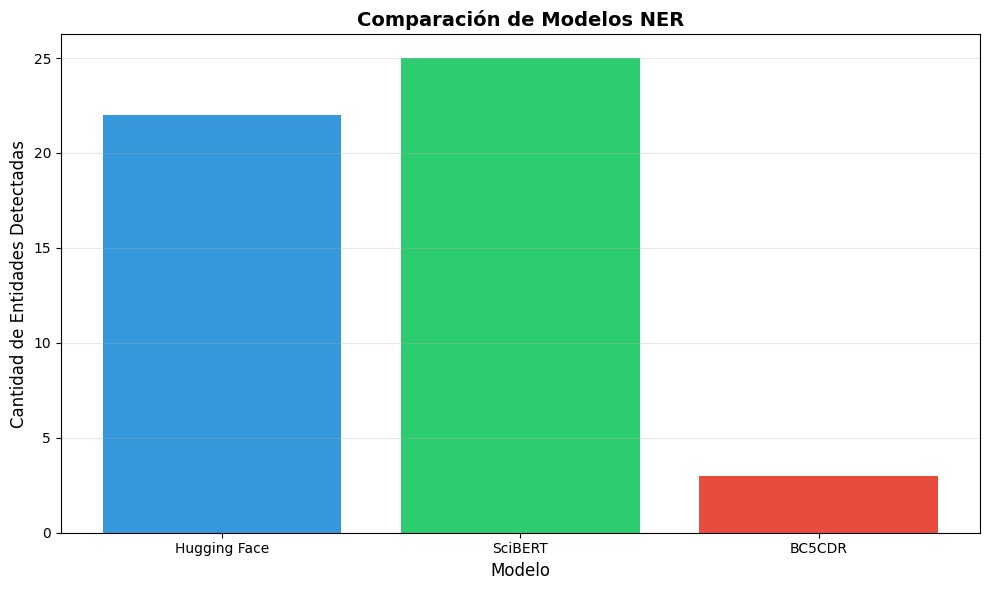

In [25]:
# Gráfico comparativo de modelos
if resultados['estadisticas']:
    plt.figure(figsize=(10, 6))
    modelos = ['Hugging Face', 'SciBERT', 'BC5CDR']
    cantidades = [
        resultados['estadisticas']['total_hf'],
        resultados['estadisticas']['total_scibert'],
        resultados['estadisticas']['total_bc5cdr']
    ]
    
    plt.bar(modelos, cantidades, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.xlabel('Modelo', fontsize=12)
    plt.ylabel('Cantidad de Entidades Detectadas', fontsize=12)
    plt.title('Comparación de Modelos NER', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
# Función auxiliar para convertir tipos numpy a tipos nativos de Python
import numpy as np

def convert_to_native_types(obj):
    """Convierte tipos numpy/tensorflow a tipos nativos de Python para serialización JSON."""
    if isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# Exportar a JSON
output_filename = 'ner_scispacy_resultados.json'

with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2, default=convert_to_native_types)

print(f"\n✅ Resultados exportados a: {output_filename}")
print(f"   Tamaño del archivo: {len(json.dumps(resultados, default=convert_to_native_types))} bytes")


✅ Resultados exportados a: ner_scispacy_resultados.json
   Tamaño del archivo: 6993 bytes


# EntityLinker

In [29]:
from scispacy.linking import EntityLinker  # ⭐ FEATURE PRINCIPAL

In [30]:
# EntityLinker con UMLS
print("⏳ Configurando EntityLinker con UMLS...")
print("   (Primera vez: descarga de ~1GB, por favor espera)")
print("   Esto puede tomar 30-60 minutos...\n")

nlp_scibert.add_pipe(
    "scispacy_linker",
    config={
        "resolve_abbreviations": True,  # Expandir abreviaturas antes de vincular
        "linker_name": "umls",           # Base de conocimiento UMLS
        "threshold": 0.75,                # Umbral de confianza (balance)
        "k": 30,                          # Candidatos a considerar
        "max_entities_per_mention": 3     # Top 3 matches por entidad
    }
)

print("✅ EntityLinker UMLS configurado")

⏳ Configurando EntityLinker con UMLS...
   (Primera vez: descarga de ~1GB, por favor espera)
   Esto puede tomar 30-60 minutos...

✅ EntityLinker UMLS configurado


In [31]:
# Acceso al linker para consultas posteriores
linker = nlp_scibert.get_pipe("scispacy_linker")
print(f"✅ Knowledge base cargada: {len(linker.kb.cui_to_entity):,} conceptos disponibles")

✅ Knowledge base cargada: 3,920,422 conceptos disponibles


In [32]:
# Mapeo de TUI (Type Unique Identifier) a categorías
TUI_CATEGORIES = {
    "ENFERMEDAD": {
        "T047",  # Disease or Syndrome
        "T046",  # Pathologic Function
        "T048",  # Mental or Behavioral Dysfunction
        "T191",  # Neoplastic Process
        "T037",  # Injury or Poisoning
        "T049",  # Cell or Molecular Dysfunction
    },
    "SINTOMA": {
        "T184",  # Sign or Symptom
        "T033",  # Finding
        "T034",  # Laboratory or Test Result
    },
    "MEDICAMENTO": {
        "T121",  # Pharmacologic Substance
        "T109",  # Organic Chemical
        "T195",  # Antibiotic
        "T200",  # Clinical Drug
        "T114",  # Nucleic Acid, Nucleoside, or Nucleotide
    },
    "ANATOMIA": {
        "T029",  # Body Location or Region
        "T023",  # Body Part, Organ, or Organ Component
        "T030",  # Body Space or Junction
        "T024",  # Tissue
    },
    "PROCEDIMIENTO": {
        "T060",  # Diagnostic Procedure
        "T061",  # Therapeutic or Preventive Procedure
        "T059",  # Laboratory Procedure
    }
}

def clasificar_por_tui(tui_codes):
    """Clasifica una entidad basándose en sus códigos TUI."""
    for categoria, tuis in TUI_CATEGORIES.items():
        if any(tui in tuis for tui in tui_codes):
            return categoria
    return "OTRO"

print("✅ Sistema de clasificación por TUI configurado")

✅ Sistema de clasificación por TUI configurado


In [33]:
def enriquecer_entidad(entidad_span, linker):
    """
    Enriquece una entidad con información de UMLS.
    
    Args:
        entidad_span: Span de spacy con la entidad
        linker: EntityLinker de scispacy
    
    Returns:
        dict con información enriquecida
    """
    entidad_info = {
        "texto_original": entidad_span.text,
        "tipo_ner": entidad_span.label_,
        "posicion": (entidad_span.start_char, entidad_span.end_char),
    }
    
    # Intentar obtener información de UMLS si está vinculada
    if hasattr(entidad_span._, 'kb_ents') and entidad_span._.kb_ents:
        # Tomar la mejor coincidencia (primera)
        umls_id, score = entidad_span._.kb_ents[0]
        
        # Obtener información completa de UMLS
        if umls_id in linker.kb.cui_to_entity:
            umls_entity = linker.kb.cui_to_entity[umls_id]
            
            entidad_info.update({
                "umls_id": umls_id,
                "nombre_normalizado": umls_entity.canonical_name,
                "definicion": umls_entity.definition if umls_entity.definition else "Sin definición disponible",
                "tipos_semanticos": list(umls_entity.types),
                "categoria": clasificar_por_tui(umls_entity.types),
                "sinonimos": list(umls_entity.aliases)[:5],  # Top 5 sinónimos
                "score_linking": round(score, 3),
            })
            
            # Obtener todas las alternativas
            alternativas = []
            for alt_id, alt_score in entidad_span._.kb_ents[1:]:
                if alt_id in linker.kb.cui_to_entity:
                    alt_entity = linker.kb.cui_to_entity[alt_id]
                    alternativas.append({
                        "umls_id": alt_id,
                        "nombre": alt_entity.canonical_name,
                        "score": round(alt_score, 3)
                    })
            
            if alternativas:
                entidad_info["alternativas"] = alternativas
    
    return entidad_info

print("✅ Función de enriquecimiento definida")

✅ Función de enriquecimiento definida


In [34]:
def procesar_texto_clinico(texto):
    """
    Pipeline completo: extracción, enriquecimiento, clasificación.
    """
    print("\n" + "="*60)
    print("🚀 INICIANDO PROCESAMIENTO NER AVANZADO CON ENTITYLINKER")
    print("="*60)
    
    # Ejecutar modelos NER
    print("\n🔍 Ejecutando modelos NER...")
    doc_scibert = nlp_scibert(texto)
    
    print(f"✅ Detectadas {len(doc_scibert.ents)} entidades")
    
    # Estructura de salida
    output = {
        "metadatos": {
            "fecha_procesamiento": datetime.now().isoformat(),
            "modelos_usados": ["en_core_sci_scibert"],
            "knowledge_base": "UMLS",
            "total_conceptos_umls": len(linker.kb.cui_to_entity)
        },
        "texto_original": texto,
        "entidades_por_categoria": defaultdict(list),
        "abreviaturas": [],
        "estadisticas": defaultdict(int)
    }
    
    # Procesar abreviaturas
    print("\n🔤 Procesando abreviaturas...")
    for abrv in doc_scibert._.abbreviations:
        output["abreviaturas"].append({
            "abreviatura": abrv.text,
            "forma_larga": abrv._.long_form.text,
            "posicion": (abrv.start_char, abrv.end_char)
        })
    print(f"   Encontradas {len(output['abreviaturas'])} abreviaturas")
    
    # Procesar y enriquecer entidades
    print("\n💎 Enriqueciendo entidades con UMLS...")
    for ent in doc_scibert.ents:
        # Enriquecer con UMLS
        entidad_enriquecida = enriquecer_entidad(ent, linker)
        
        # Detectar contexto
        contexto = detectar_contexto(texto, ent.text, (ent.start_char, ent.end_char))
        entidad_enriquecida["contexto"] = contexto
        
        # Clasificar por categoría
        categoria = entidad_enriquecida.get("categoria", "OTRO")
        output["entidades_por_categoria"][categoria].append(entidad_enriquecida)
        output["estadisticas"][categoria] += 1
    
    # Convertir defaultdict a dict normal para JSON
    output["entidades_por_categoria"] = dict(output["entidades_por_categoria"])
    output["estadisticas"] = dict(output["estadisticas"])
    
    print("\n" + "="*60)
    print("✅ PROCESAMIENTO COMPLETADO")
    print("="*60)
    
    return output

print("✅ Pipeline completo definido")

✅ Pipeline completo definido


In [35]:
resultados = procesar_texto_clinico(historia_clinica)


🚀 INICIANDO PROCESAMIENTO NER AVANZADO CON ENTITYLINKER

🔍 Ejecutando modelos NER...
✅ Detectadas 25 entidades

🔤 Procesando abreviaturas...
   Encontradas 0 abreviaturas

💎 Enriqueciendo entidades con UMLS...

✅ PROCESAMIENTO COMPLETADO


In [36]:
# Mostrar estadísticas generales
print("\n" + "="*60)
print("📊 ESTADÍSTICAS GENERALES")
print("="*60)
print(f"\n📅 Fecha de procesamiento: {resultados['metadatos']['fecha_procesamiento']}")
print(f"🗄️  Conceptos UMLS disponibles: {resultados['metadatos']['total_conceptos_umls']:,}")
print(f"🔤 Abreviaturas detectadas: {len(resultados['abreviaturas'])}")

print(f"\n🏷️  Entidades por categoría:")
for categoria, cantidad in resultados['estadisticas'].items():
    print(f"   - {categoria}: {cantidad}")


📊 ESTADÍSTICAS GENERALES

📅 Fecha de procesamiento: 2025-12-03T03:04:47.403306
🗄️  Conceptos UMLS disponibles: 3,920,422
🔤 Abreviaturas detectadas: 0

🏷️  Entidades por categoría:
   - OTRO: 23
   - PROCEDIMIENTO: 1
   - ENFERMEDAD: 1


In [37]:
# Mostrar enfermedades detectadas CON INFORMACIÓN UMLS
if "ENFERMEDAD" in resultados['entidades_por_categoria']:
    print("\n" + "="*60)
    print("🏥 ENFERMEDADES DETECTADAS (con UMLS)")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_por_categoria']['ENFERMEDAD'], 1):
        print(f"\n[{i}] {ent['texto_original']}")
        if 'umls_id' in ent:
            print(f"    🆔 UMLS CUI: {ent['umls_id']}")
            print(f"    📝 Nombre normalizado: {ent['nombre_normalizado']}")
            print(f"    🏷️  Tipo semántico: {', '.join(ent['tipos_semanticos'])}")
            print(f"    ✅ Confianza linking: {ent['score_linking']}")
            print(f"    📖 Definición: {ent['definicion'][:150]}..." if len(ent['definicion']) > 150 else f"    📖 Definición: {ent['definicion']}")
            
            if ent['contexto'].get('temporalidad'):
                print(f"    ⏰ Temporalidad: {ent['contexto']['temporalidad']}")
            if ent['contexto']['negacion']:
                print(f"    ❌ NEGADO")
            
            if 'alternativas' in ent and ent['alternativas']:
                print(f"\n    🔄 Conceptos alternativos:")
                for alt in ent['alternativas'][:2]:
                    print(f"       • {alt['nombre']} (CUI: {alt['umls_id']}, score: {alt['score']})")


🏥 ENFERMEDADES DETECTADAS (con UMLS)

[1] Diabetes Mellitus tipo 2
    🆔 UMLS CUI: C0011849
    📝 Nombre normalizado: Diabetes Mellitus
    🏷️  Tipo semántico: T047
    ✅ Confianza linking: 0.851
    📖 Definición: A heterogeneous group of disorders characterized by HYPERGLYCEMIA and GLUCOSE INTOLERANCE.
    ⏰ Temporalidad: actual

    🔄 Conceptos alternativos:
       • Diabetes Mellitus, Non-Insulin-Dependent (CUI: C0011860, score: 0.781)
       • Diabetic Diet (CUI: C0011878, score: 0.758)


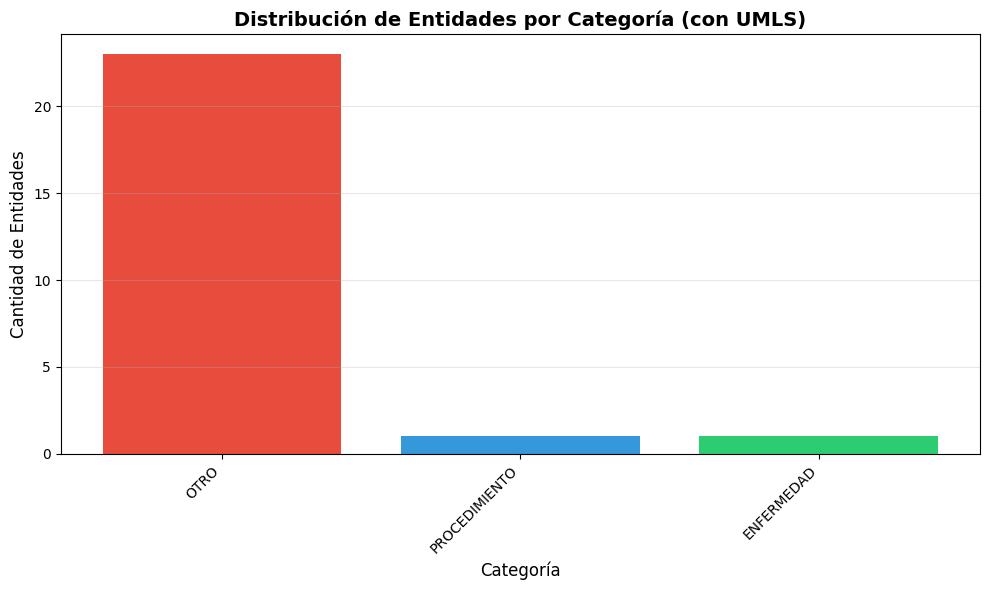

In [39]:
# Gráfico de distribución de categorías
if resultados['estadisticas']:
    plt.figure(figsize=(10, 6))
    categorias = list(resultados['estadisticas'].keys())
    cantidades = list(resultados['estadisticas'].values())
    
    plt.bar(categorias, cantidades, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'])
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Cantidad de Entidades', fontsize=12)
    plt.title('Distribución de Entidades por Categoría (con UMLS)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [40]:
# Exportar a JSON
output_filename = 'ner_entitylinker_resultados.json'

with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)

print(f"\n✅ Resultados exportados a: {output_filename}")
print(f"   Tamaño del archivo: {len(json.dumps(resultados)):,} bytes")


✅ Resultados exportados a: ner_entitylinker_resultados.json
   Tamaño del archivo: 8,401 bytes
